In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import torch.nn.functional as F

# Question 1

In [2]:
# Define CNN Model
class FaceGuardCNN(nn.Module):
    def __init__(self):
        super(FaceGuardCNN, self).__init__() # Always call parent's constructor (nn.Module)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)  # Output: 8 x 64 x 64
        self.relu = nn.ReLU() # ReLU activation function
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # Pooling layer with kernel size 2 and stride 2
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2) # Output: 16 x 32 x 32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) # Output: 32 x 32 x 32
        
        # Adjust linear layer input dimensions accordingly
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # after pooling thrice: 64->32->16->8
        self.fc2 = nn.Linear(128, 64) # 64 individuals
        self.fc2 = nn.Linear(128, 40)  # 40 individuals

    def forward(self, x): # Forward pass
        x = self.pool(self.relu(self.conv1(x))) # 8 x 32 x 32
        x = self.pool(self.relu(self.conv2(x))) # 16 x 16 x 16
        x = self.pool(self.relu(self.conv3(x))) # 32 x 8 x 8
        
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x)) # Fully connected layer
        x = self.fc2(x)  # Output layer (no activation here since CrossEntropyLoss applies softmax internally)
        
        return x

# Instantiate and print model
model = FaceGuardCNN()
print(model)

FaceGuardCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=40, bias=True)
)


In [3]:
dataset_path = '/Users/hazemmahmoud/Desktop/Cyber-AI/AI CW/archive' # Change this to your dataset path

# Load data
images = np.load(os.path.join(dataset_path, 'augmented_faces.npy')).reshape(-1, 64 * 64) # 64x64 images
labels = np.load(os.path.join(dataset_path, 'augmented_labels.npy')) # 40 classes

# Normalize images and reshape
images = images.reshape(-1, 64, 64).astype(np.float32) # Reshape to (N, 64, 64)
images = np.expand_dims(images, axis=1) # Add channel dimension (N, 1,64, 64)

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Custom Dataset Class
class OlivettiDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray((self.images[idx].squeeze() * 255).astype(np.uint8), mode='L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create Train & Test Datasets
train_dataset = OlivettiDataset(train_images, train_labels, transform=train_transform)
test_dataset = OlivettiDataset(test_images, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1, Loss: 3.6775
Epoch 2, Loss: 2.6274
Epoch 3, Loss: 1.9365
Epoch 4, Loss: 1.6788
Epoch 5, Loss: 1.4053
Epoch 6, Loss: 0.9161
Epoch 7, Loss: 1.0141
Epoch 8, Loss: 0.8692
Epoch 9, Loss: 1.0405
Epoch 10, Loss: 0.3923
Epoch 11, Loss: 0.4674
Epoch 12, Loss: 0.5564
Epoch 13, Loss: 0.3326
Epoch 14, Loss: 0.3538
Epoch 15, Loss: 0.0631
Epoch 16, Loss: 0.6437
Epoch 17, Loss: 0.5640
Epoch 18, Loss: 0.1291
Epoch 19, Loss: 0.1886
Epoch 20, Loss: 0.2327
Epoch 21, Loss: 0.3305
Epoch 22, Loss: 0.1878
Epoch 23, Loss: 0.3440
Epoch 24, Loss: 0.2851
Epoch 25, Loss: 0.1455
Epoch 26, Loss: 0.2197
Epoch 27, Loss: 0.2858
Epoch 28, Loss: 0.3507
Epoch 29, Loss: 0.2175
Epoch 30, Loss: 0.0845
Epoch 31, Loss: 0.1796
Epoch 32, Loss: 0.1107
Epoch 33, Loss: 0.2805
Epoch 34, Loss: 0.1640
Epoch 35, Loss: 0.8430
Epoch 36, Loss: 0.0779
Epoch 37, Loss: 0.0721
Epoch 38, Loss: 0.0245
Epoch 39, Loss: 0.2100
Epoch 40, Loss: 0.1378
Epoch 41, Loss: 0.2407
Epoch 42, Loss: 0.0863
Epoch 43, Loss: 0.2282
Epoch 44, Loss: 0.00

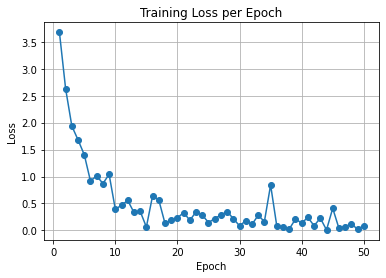

In [4]:
# Assuming `train_loader` and `model` are already defined
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

epochs = 50  # Number of epochs
loss_values = []  # To store loss for each epoch

for epoch in range(epochs): # Loop over the dataset multiple times
    for inputs, labels in train_loader:  # Loop over the dataset
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')  # Print the loss
    loss_values.append(loss.item())  # Store loss value

# Plot the loss values
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()


In [5]:
model.eval() # Set the model to evaluation mode
correct = 0 # Number of correct predictions
total = 0 # Total number of samples

with torch.no_grad(): # Disable gradient
    for inputs, labels in test_loader: # Loop over the test dataset
        outputs = model(inputs) # Forward pass
        _, predicted = torch.max(outputs.data, 1) # Get the predicted class
        total += labels.size(0) # Get the total number of samples
        correct += (predicted == labels).sum().item() # Get the number of correct predictions

accuracy = 100 * correct / total # Compute the accuracy
print(f'Test Accuracy: {accuracy:.2f}%') # Print the accuracy

Test Accuracy: 98.50%


In [ ]:
authorized_ids = {0, 5, 10} # Authorized IDs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available


def Access_Control(image, model, transform): # Access control function
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient
        image_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension
        output = model(image_tensor) # Forward pass
        _, predicted = torch.max(output, 1) # Get the predicted class
        predicted_id = predicted.item() # Get the predicted class ID
        if predicted_id in authorized_ids: # Check if the predicted ID is in the authorized IDs
            print("Access Granted")
        else:
            print("Access Denied")

In [ ]:
authorized_ids = {0, 5, 10} # Authorized IDs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # Move model to GPU if available

# Collect all indices of test samples with label 0, 5, or 10
selected_indices = [i for i, (_, label) in enumerate(test_dataset) if label in authorized_ids]

# You can limit to 10 if needed
selected_indices = random.sample(selected_indices, min(5, len(selected_indices)))

# Loop over selected samples
for idx in selected_indices: # Loop over selected samples
    img, label = test_dataset[idx] # Get image and label
    img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension
    prediction = model(img_tensor).argmax(1).item() # Get the predicted class ID

    img_pil = transforms.ToPILImage()(img.cpu())  # Convert back to CPU for PIL
    print(f'Predicted ID: {prediction}')
    print(f'Actual ID: {label}')
    Access_Control(img_pil, model, test_transform)
    print('-' * 30)

Predicted ID: 5
Actual ID: 5
Access Granted
------------------------------
Predicted ID: 0
Actual ID: 0
Access Granted
------------------------------
Predicted ID: 10
Actual ID: 10
Access Granted
------------------------------
Predicted ID: 0
Actual ID: 0
Access Granted
------------------------------
Predicted ID: 0
Actual ID: 0
Access Granted
------------------------------


In [8]:
# Randomly select 10 samples
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available
model.to(device) # Move the model to the device
Faces = random.sample(range(len(test_dataset)), 10) # Randomly select 10 samples

for idx in Faces: # Loop over the faces
    img, label = test_dataset[idx] # Get the image and label
    img = img.to(device) # Move the image to the device
    img_pil = transforms.ToPILImage()(img) # Convert the image to PIL format
    print(f'Predicted ID: {model(img.unsqueeze(0)).argmax(1).item()}') # Print the predicted ID
    print(f'Actual ID: {label}') # Print the actual ID
    Access_Control(img_pil, model, test_transform) # Access Control
    print('-' * 30)

Predicted ID: 14
Actual ID: 14
Access Denied
------------------------------
Predicted ID: 16
Actual ID: 16
Access Denied
------------------------------
Predicted ID: 38
Actual ID: 38
Access Denied
------------------------------
Predicted ID: 24
Actual ID: 24
Access Denied
------------------------------
Predicted ID: 10
Actual ID: 10
Access Granted
------------------------------
Predicted ID: 21
Actual ID: 21
Access Denied
------------------------------
Predicted ID: 39
Actual ID: 39
Access Denied
------------------------------
Predicted ID: 33
Actual ID: 33
Access Denied
------------------------------
Predicted ID: 16
Actual ID: 16
Access Denied
------------------------------
Predicted ID: 5
Actual ID: 5
Access Granted
------------------------------


# Question 2 Un-Targeted FGSM

In [ ]:
# x = images of the faces
# y = labels of the faces
def FGSM_untargeted(model, x, y, epsilon=0.1):
    x_adv = x.clone().detach().requires_grad_(True) # clone and set requires_grad
    output = model(x_adv) # forward pass
    loss = nn.CrossEntropyLoss()(output, y) # calculate the loss
    model.zero_grad() # zero all existing gradients
    loss.backward() # calculate gradients


    # Collect the element-wise sign of the data gradient
    sign_data_grad = x_adv.grad.data.sign()


    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = x_adv + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def compute_Adv_accuracy(model, loader, epsilon, device):
    model.eval()
    correct, total = 0, 0 # Initialize the number of correct and total predictions
    for images, labels in loader: # Loop over the test dataset
        images, labels = images.to(device), labels.to(device) # Move images and labels to the device

        # Generate adversarial examples using FGSM
        images_adv = FGSM_untargeted(model, images, labels, epsilon) 

        with torch.no_grad(): # Disable gradient
            outputs = model(images_adv) # Forward pass
            _, predicted = torch.max(outputs, 1) # Get the predicted class
        total += labels.size(0) # Get the total number of samples
        correct += (predicted == labels).sum().item() # Get the number of correct predictions
    accuracy = correct / total # Compute the accuracy
    return accuracy # Return the accuracy


print(f'Accuracy on clean images: {compute_Adv_accuracy(model, test_loader, 0, device) * 100:.2f}%') # Clean images
print(f'Accuracy on adversarial images: {compute_Adv_accuracy(model, test_loader, 0.05, device) * 100:.2f}%') # Adversarial images

Accuracy on clean images: 98.50%
Accuracy on adversarial images: 4.00%


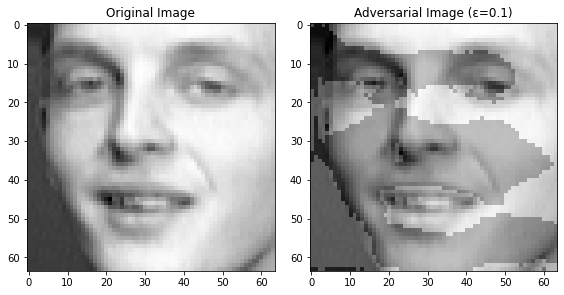

In [ ]:
img, label = test_dataset[0]  # Get sample
img = img.unsqueeze(0).to(device)  # Add batch dim and move to device
label = torch.tensor([label]).to(device) # Convert label to tensor and move to device

# Generate adversarial image
epsilon = 0.1 # Set epsilon = attack strength
adv_img = FGSM_untargeted(model, img, label, epsilon) # Generate adversarial image

# Convert both to PIL for display
original_pil = to_pil_image(img.squeeze().cpu()) # Convert to PIL
adv_pil = to_pil_image(adv_img.squeeze().detach().cpu()) # Convert to PIL

# Plot original vs adversarial
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(original_pil, cmap='gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(adv_pil, cmap='gray')
plt.title(f"Adversarial Image (ε={epsilon})")

plt.tight_layout()
plt.show()

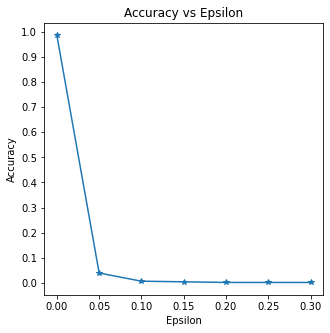

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3] # Epsilon values
accuracies = [] # To store accuracies
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for eps in epsilons:
    acc = compute_Adv_accuracy(model, test_loader, eps, device) # Compute accuracy
    accuracies.append(acc) # Store accuracy

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .31, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

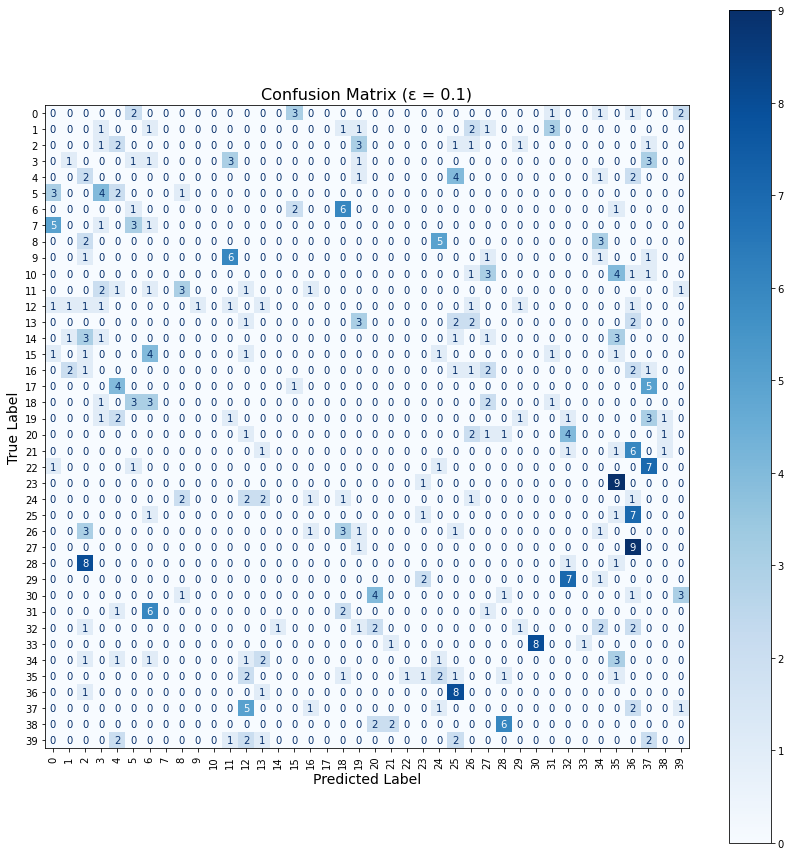

In [ ]:
def generate_confusion_matrix(model, loader, epsilon, device):
    model.eval()
    all_preds = [] # Initialize the predictions
    all_labels = [] # Initialize the labels

    for images, labels in loader: # Loop over the test dataset
        images, labels = images.to(device), labels.to(device) # Move images and labels to the device
        adv_images = FGSM_untargeted(model, images, labels, epsilon) # Generate adversarial images

        with torch.no_grad(): # Disable gradient
            outputs = model(adv_images) # Forward pass
            _, predicted = torch.max(outputs, 1) # Get the predicted class

        all_preds.extend(predicted.cpu().numpy()) # Append the predictions
        all_labels.extend(labels.cpu().numpy()) # Append the labels

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(40))  # Ensure all labels from 0 to 39
    fig, ax = plt.subplots(figsize=(12, 12))  # Make the figure larger

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(40)) # Display the confusion matrix
    disp.plot(cmap="Blues", xticks_rotation=90, ax=ax, colorbar=True) # Plot the confusion matrix

    plt.title(f"Confusion Matrix (ε = {epsilon})", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    epsilon = 0.1  # or any value from your attack range
generate_confusion_matrix(model, test_loader, epsilon, device)

# Question 2 Targeted FGSM

In [ ]:
# x = images of the faces
# y = labels of the faces
def FGSM_targeted(model, x, y, epsilon=0.1):
    x_adv = x.clone().detach().requires_grad_(True) # clone and set requires_grad
    output = model(x_adv) # Forward pass
    loss = nn.CrossEntropyLoss()(output, y) # Compute the loss
    model.zero_grad() # Zero all existing gradients
    loss.backward() #Backpropagate
    x_adv = x_adv - epsilon * x_adv.grad.sign() # FGSM
    x_adv = torch.clamp(x_adv, 0, 1) # Clip the perturbation to maintain [0,1] range
    return x_adv # Return the perturbed image

In [15]:
def compute_Adv_accuracy_targeted(model, image_path, epsilon, device, target_id=None):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((64, 64)), # Resize to 64x64
        transforms.Grayscale(), # Convert to grayscale
        transforms.ToTensor(), # Convert to tensor
    ])

    image = Image.open(image_path).convert("L") # Load image and convert to grayscale
    image = transform(image).unsqueeze(0).to(device) # Add batch dimension and move to device

    # Determine the target class
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient
        output = model(image) # Forward pass
        predicted_class = torch.argmax(output, dim=1).item() # Get the predicted class

    if target_id is None: # If target is not specified, default to self-targeted attack
        target_id = predicted_class  # Default to self-targeted attack

    target_label = torch.tensor([target_id], dtype=torch.long).to(device) # Convert target to tensor

    # Generate adversarial image
    adv_image = FGSM_targeted(model, image, target_label, epsilon=epsilon)

    # Predict after attack
    with torch.no_grad():
        adv_output = model(adv_image) # Forward pass
        adv_pred = torch.argmax(adv_output, dim=1).item() # Get the predicted class

    # Display results
    print(f"Original predicted class: {predicted_class}")
    print(f"Target class for attack: {target_id}")
    print(f"Model prediction after attack: {adv_pred}")

    # Show adversarial image
    adv_img_np = adv_image.squeeze().detach().cpu().numpy()
    plt.imshow(adv_img_np, cmap='gray')
    plt.title(f"Adversarial Image\nTarget: {target_id} | Predicted: {adv_pred}")
    plt.axis('off')
    plt.show()

Original predicted class: 10
Target class for attack: 0
Model prediction after attack: 0


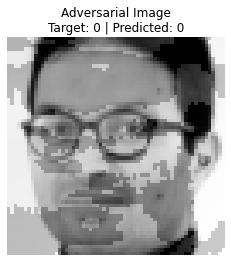

Original predicted class: 10
Target class for attack: 5
Model prediction after attack: 7


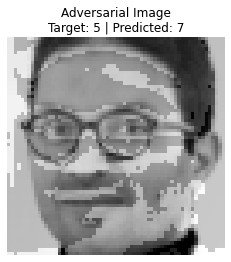

Original predicted class: 10
Target class for attack: 10
Model prediction after attack: 10


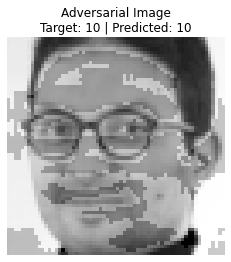

In [21]:
# Force the model to misclassify into class 0
compute_Adv_accuracy_targeted(model, image_path="/Users/hazemmahmoud/Desktop/Cyber-AI/AI CW/face_cropped.jpg", epsilon=0.1, device=device, target_id=0)
# Force the model to misclassify into class 5
compute_Adv_accuracy_targeted(model, image_path="/Users/hazemmahmoud/Desktop/Cyber-AI/AI CW/face_cropped.jpg", epsilon=0.1, device=device, target_id=5)
# Force the model to misclassify into class 10
compute_Adv_accuracy_targeted(model, image_path="/Users/hazemmahmoud/Desktop/Cyber-AI/AI CW/face_cropped.jpg", epsilon=0.1, device=device, target_id=10)

# Question 3 Adversarial Training

In [ ]:
def Robust_FaceGuard(model, train_loader, optimizer, epsilon, alpha=0.01, num_iter=10, epochs=10):
    model.train() # Set the model to training mode
    criterion = torch.nn.CrossEntropyLoss() # Loss function

    for epoch in range(epochs):
        running_loss = 0.0 # Initialize running loss
        correct, total = 0, 0 # Initialize the number of correct and total predictions

        for images, labels in train_loader: # Loop over the training dataset
            images, labels = images.to(device), labels.to(device) # Move images and labels to the device
            adv_images = FGSM_untargeted(model, images, labels, epsilon) # Generate adversarial images

            optimizer.zero_grad() # Zero all existing gradients
            outputs = model(adv_images) # Forward pass
            loss = criterion(outputs, labels) # Compute the loss
            loss.backward() # Backpropagate
            optimizer.step() # Update the weights

            running_loss += loss.item() # Accumulate the loss
            _, predicted = torch.max(outputs, 1) # Get the predicted class
            correct += (predicted == labels).sum().item() # Get the number of correct predictions
            total += labels.size(0) # Get the total number of samples

        avg_loss = running_loss / len(train_loader) # Compute the average loss
        accuracy = correct / total # Compute the accuracy
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceGuardCNN().to(device)
criteron = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
Robust_FaceGuard(model, train_loader, optimizer, 0.03, epochs=50)

Epoch [1/50], Loss: 3.6925, Accuracy: 0.0175
Epoch [2/50], Loss: 3.6898, Accuracy: 0.0238
Epoch [3/50], Loss: 3.6800, Accuracy: 0.0306
Epoch [4/50], Loss: 3.5186, Accuracy: 0.0706
Epoch [5/50], Loss: 3.2724, Accuracy: 0.1119
Epoch [6/50], Loss: 3.0552, Accuracy: 0.1244
Epoch [7/50], Loss: 2.8871, Accuracy: 0.1812
Epoch [8/50], Loss: 2.8116, Accuracy: 0.1787
Epoch [9/50], Loss: 2.5727, Accuracy: 0.2306
Epoch [10/50], Loss: 2.4486, Accuracy: 0.2444
Epoch [11/50], Loss: 2.3892, Accuracy: 0.2475
Epoch [12/50], Loss: 2.2205, Accuracy: 0.3038
Epoch [13/50], Loss: 2.1314, Accuracy: 0.3081
Epoch [14/50], Loss: 2.0392, Accuracy: 0.3356
Epoch [15/50], Loss: 1.9603, Accuracy: 0.3244
Epoch [16/50], Loss: 1.8949, Accuracy: 0.3738
Epoch [17/50], Loss: 1.7924, Accuracy: 0.3769
Epoch [18/50], Loss: 1.8207, Accuracy: 0.3812
Epoch [19/50], Loss: 1.7858, Accuracy: 0.3950
Epoch [20/50], Loss: 1.6605, Accuracy: 0.4213
Epoch [21/50], Loss: 1.6269, Accuracy: 0.4394
Epoch [22/50], Loss: 1.5907, Accuracy: 0.45

Epoch [1/5], Loss: 0.1633, Accuracy: 0.9631
Epoch [2/5], Loss: 0.1250, Accuracy: 0.9712
Epoch [3/5], Loss: 0.1043, Accuracy: 0.9756
Epoch [4/5], Loss: 0.1092, Accuracy: 0.9744
Epoch [5/5], Loss: 0.0932, Accuracy: 0.9762


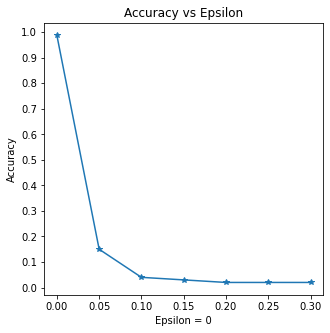

Epoch [1/5], Loss: 2.5955, Accuracy: 0.2169
Epoch [2/5], Loss: 1.9907, Accuracy: 0.2875
Epoch [3/5], Loss: 1.8815, Accuracy: 0.3194
Epoch [4/5], Loss: 1.9044, Accuracy: 0.3212
Epoch [5/5], Loss: 1.9243, Accuracy: 0.3287


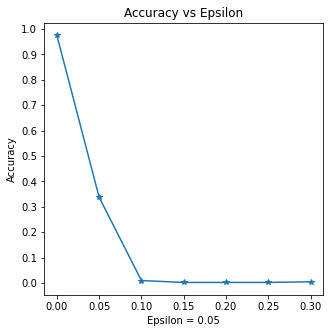

Epoch [1/5], Loss: 3.5562, Accuracy: 0.0456
Epoch [2/5], Loss: 3.3227, Accuracy: 0.0725
Epoch [3/5], Loss: 3.2513, Accuracy: 0.0781
Epoch [4/5], Loss: 3.2490, Accuracy: 0.0819
Epoch [5/5], Loss: 3.2088, Accuracy: 0.0906


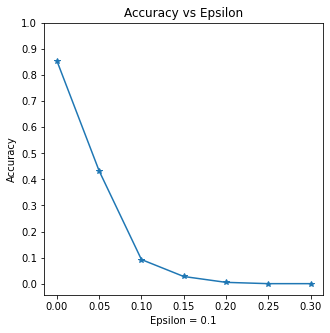

Epoch [1/5], Loss: 3.7534, Accuracy: 0.0362
Epoch [2/5], Loss: 3.5931, Accuracy: 0.0488
Epoch [3/5], Loss: 3.5754, Accuracy: 0.0519
Epoch [4/5], Loss: 3.5564, Accuracy: 0.0556
Epoch [5/5], Loss: 3.5184, Accuracy: 0.0606


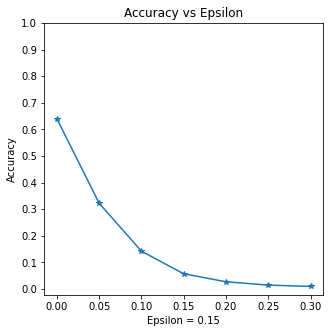

Epoch [1/5], Loss: 3.6824, Accuracy: 0.0456
Epoch [2/5], Loss: 3.6242, Accuracy: 0.0625
Epoch [3/5], Loss: 3.5711, Accuracy: 0.0706
Epoch [4/5], Loss: 3.3898, Accuracy: 0.0981
Epoch [5/5], Loss: 3.1545, Accuracy: 0.1537


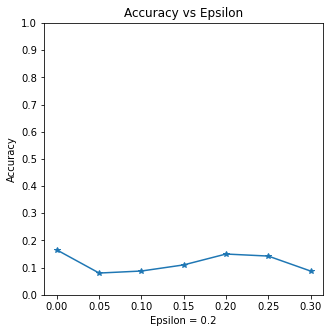

Epoch [1/5], Loss: 2.8326, Accuracy: 0.2087
Epoch [2/5], Loss: 2.4952, Accuracy: 0.2906
Epoch [3/5], Loss: 2.2432, Accuracy: 0.3500
Epoch [4/5], Loss: 2.0013, Accuracy: 0.4131
Epoch [5/5], Loss: 1.7133, Accuracy: 0.5100


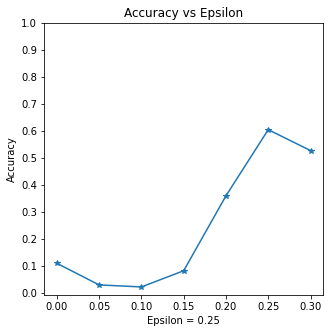

Epoch [1/5], Loss: 1.4579, Accuracy: 0.5619
Epoch [2/5], Loss: 1.1910, Accuracy: 0.6406
Epoch [3/5], Loss: 1.0809, Accuracy: 0.6744
Epoch [4/5], Loss: 0.8527, Accuracy: 0.7531
Epoch [5/5], Loss: 0.8069, Accuracy: 0.7512


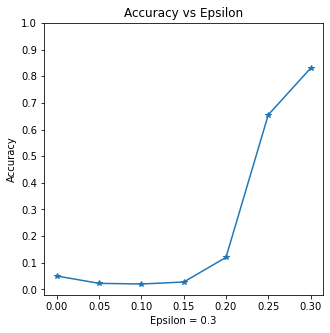

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3] # Epsilon values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for eps in epsilons: # Loop over the epsilon values
    Robust_FaceGuard(model, train_loader, optimizer, epsilon=eps, epochs = 5) # Train the model
    Acc_AT = [] # Initialize the accuracy list
    for delta in epsilons: # Loop over the epsilon values
        acc = compute_Adv_accuracy(model, test_loader, delta, device) # Compute the accuracy
        Acc_AT.append(acc) # Store the accuracy

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, Acc_AT, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .31, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel(f"Epsilon = {eps}")
    plt.ylabel("Accuracy")
    plt.show()